In [128]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')


from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Embedding,LSTM,Bidirectional,Dropout,GlobalAveragePooling1D
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.models import load_model
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay,classification_report


from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import ConfusionMatrixDisplay,classification_report,accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\17573\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\17573\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\17573\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\17573\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


# Data cleaning

In [129]:
df=pd.read_csv("train.csv")

In [130]:
df.head(20)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1


In [131]:
np.array(df["text"])

array(['Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all',
       'Forest fire near La Ronge Sask. Canada',
       "All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected",
       ...,
       'M1.94 [01:04 UTC]?5km S of Volcano Hawaii. http://t.co/zDtoyd8EbJ',
       'Police investigating after an e-bike collided with a car in Little Portugal. E-bike rider suffered serious non-life threatening injuries.',
       'The Latest: More Homes Razed by Northern California Wildfire - ABC News http://t.co/YmY4rSkQ3d'],
      dtype=object)

In [132]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


<AxesSubplot:xlabel='target', ylabel='count'>

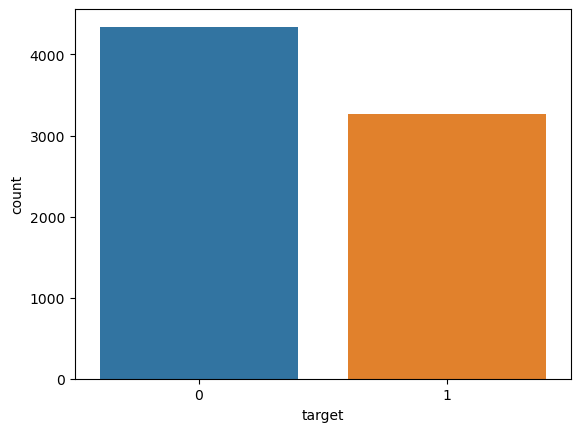

In [133]:
sns.countplot(x=df["target"])
#there is no big imbalance between two categories

In [134]:
df["text"]

0       Our Deeds are the Reason of this #earthquake M...
1                  Forest fire near La Ronge Sask. Canada
2       All residents asked to 'shelter in place' are ...
3       13,000 people receive #wildfires evacuation or...
4       Just got sent this photo from Ruby #Alaska as ...
                              ...                        
7608    Two giant cranes holding a bridge collapse int...
7609    @aria_ahrary @TheTawniest The out of control w...
7610    M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...
7611    Police investigating after an e-bike collided ...
7612    The Latest: More Homes Razed by Northern Calif...
Name: text, Length: 7613, dtype: object

In [135]:
def clean_text(text):
    text = text.lower()  # Lowercasing
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'@\w+', '', text)  # Remove mentions
    text = re.sub(r'#\w+', '', text)  # Remove hashtags
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    text = re.sub(r'\d+', '', text)  # Remove numbers
    tokens = word_tokenize(text)  # Tokenization
    tokens = [word for word in tokens if word not in stopwords.words('english')]  # Remove stop words
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]  # Lemmatization
    cleaned_text = ' '.join(tokens)  # Join tokens back into a string
    return cleaned_text

In [136]:
df["text"][0]

'Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all'

In [137]:
df["text"]=df["text"].apply(clean_text)

In [138]:
df["text"][0]

'deed reason may allah forgive u'

In [139]:
X=df["text"]
y=df["target"]

In [140]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [141]:
#Tokenize the text by creating word_index dictionary
#tokenizer=Tokenizer(num_words=N_words,oov_token="<OOV>")  # OOV stands for out of vocabulary index(all uncommon words will be associated with index=1, index=0 is reserved for padding)
tokenizer=Tokenizer(oov_token="<OOV>")

In [142]:
#every word gets a unique integer value
tokenizer.fit_on_texts(X_train)

In [143]:
#print(tokenizer.word_index)

In [144]:
# Get the vocabulary length
N_words = len(tokenizer.word_index)+1
# we need vocabulary of size len(word_index) + 1 to be able to index up to the greatest token ID

In [145]:
N_words

9916

In [146]:
X_train.shape

(5100,)

In [147]:
#Transforms each text in texts to a sequence of integers. 
#It takes each word in the text and replaces it with its corresponding integer value from the word_index dictionary.
sequences=tokenizer.texts_to_sequences(X_train)

In [148]:
sequences[0]

[110, 4193, 4194, 264, 569]

In [149]:
# Pad the sequences to a maximum length
padded_sequences = pad_sequences(sequences,padding='post', truncating='post')

In [150]:
padded_sequences.shape

(5100, 23)

In [151]:
padded_sequences[0]

array([ 110, 4193, 4194,  264,  569,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0])

In [152]:
max_seq_len=padded_sequences.shape[1]

In [153]:
max_seq_len

23

In [154]:
# Convert labels to numpy array
train_labels = np.array(y_train)

In [155]:
labels=to_categorical(train_labels) #especially important for multiclass case

In [156]:
#Get text sequences
sequences_test=tokenizer.texts_to_sequences(X_test)

In [157]:
#padded test sequences
#set_max_len equal to the one from train sample
padded_sequences_test = pad_sequences(sequences_test,padding='post', truncating='post',maxlen=max_seq_len)#

In [158]:
padded_sequences_test.shape

(2513, 23)

In [159]:
type(padded_sequences_test)

numpy.ndarray

In [160]:
#test labels
test_labels=np.array(y_test)

In [161]:
test_labels.shape

(2513,)

In [162]:
labels_test=to_categorical(test_labels)

# Model

In [163]:
model = Sequential()
model.add(Embedding(N_words, 256, input_length=max_seq_len))
model.add(Dropout(0.5))
model.add(LSTM(64))
model.add(Dense(2, activation='sigmoid'))

In [164]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [165]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 23, 256)           2538496   
                                                                 
 dropout_2 (Dropout)         (None, 23, 256)           0         
                                                                 
 lstm_2 (LSTM)               (None, 64)                82176     
                                                                 
 dense_2 (Dense)             (None, 2)                 130       
                                                                 
Total params: 2,620,802
Trainable params: 2,620,802
Non-trainable params: 0
_________________________________________________________________


In [166]:
early_stop=EarlyStopping(monitor="val_loss",mode="min",verbose=1,patience=1)#Track validation loss, try to minimize it, have little report , wait 25 epochs before stopping

In [167]:
# Train the model
model.fit(
    padded_sequences,
    labels,
    epochs=10,
    batch_size=2,
#    validation_split=0.2,
    validation_data=(padded_sequences_test, labels_test),
    verbose=1,
    callbacks=[early_stop]
)

Epoch 1/10
2550/2550 [==============================] - 55s 21ms/step - loss: 0.5745 - accuracy: 0.7125 - val_loss: 0.4797 - val_accuracy: 0.7986
Epoch 2/10
2550/2550 [==============================] - 52s 21ms/step - loss: 0.3616 - accuracy: 0.8498 - val_loss: 0.5262 - val_accuracy: 0.7382
Epoch 2: early stopping


In [168]:
losses_earlystop=pd.DataFrame(model.history.history)

<AxesSubplot:>

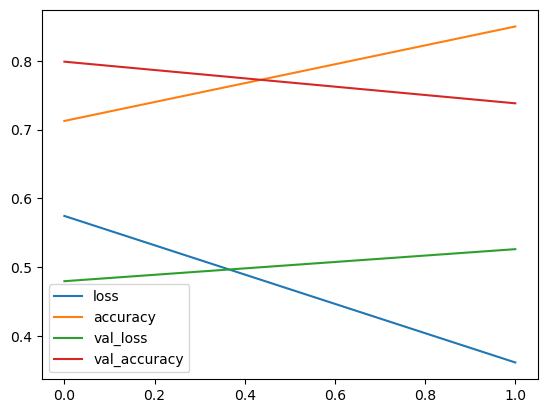

In [169]:
losses_earlystop.plot()

In [170]:
results = model.evaluate(padded_sequences_test, labels_test)
print(results)

79/79 [==============================] - 0s 5ms/step - loss: 0.5262 - accuracy: 0.7382
[0.5262407660484314, 0.738161563873291]


In [171]:
test_predictions = model.predict(padded_sequences_test)

79/79 [==============================] - 1s 4ms/step


In [172]:
test_clas1=test_predictions[:,1]

In [173]:
test_prob_redictions = np.round(test_clas1)

In [174]:
test_prob_redictions.shape

(2513,)

In [175]:
test_prob_redictions.reshape(2513,)

array([0., 1., 1., ..., 1., 1., 0.], dtype=float32)

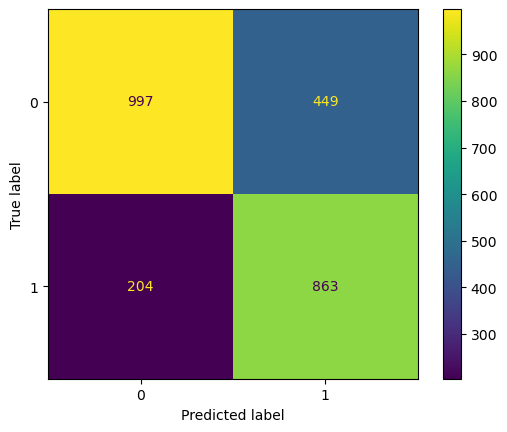

In [176]:
ConfusionMatrixDisplay.from_predictions(test_labels,test_prob_redictions)

In [177]:
print(classification_report(test_labels,test_prob_redictions))

              precision    recall  f1-score   support

           0       0.83      0.69      0.75      1446
           1       0.66      0.81      0.73      1067

    accuracy                           0.74      2513
   macro avg       0.74      0.75      0.74      2513
weighted avg       0.76      0.74      0.74      2513



In [178]:
#Sample test review
sample_text = "We are evacuating because of tornado!"
sample_sequence = tokenizer.texts_to_sequences([sample_text])
sample_padded_sequence = pad_sequences(sample_sequence, maxlen=max_seq_len, padding='post', truncating='post')

In [179]:
# Make prediction
prediction = model.predict(sample_padded_sequence)

1/1 [==============================] - 0s 19ms/step


In [180]:
prediction

array([[0.18499626, 0.807118  ]], dtype=float32)

In [181]:
print(f"Review: {sample_text}")
print(f"Predicted Sentiment: {'Positive' if prediction[:,1] > 0.5 else 'Negative'} (Score: {prediction[:,1]})")

Review: We are evacuating because of tornado!
Predicted Sentiment: Positive (Score: [0.807118])


In [182]:
df_test=pd.read_csv("test.csv")

In [183]:
df_test.head(20)

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan
5,12,NaN,NaN,We're shaking...It's an earthquake
6,21,NaN,NaN,They'd probably still show more life than Arse...
7,22,NaN,NaN,Hey! How are you?
8,27,NaN,NaN,What a nice hat?
9,29,NaN,NaN,Fuck off!


In [184]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


In [185]:
test_sequence = tokenizer.texts_to_sequences(df_test["text"])
test_padded_sequence = pad_sequences(test_sequence, maxlen=max_seq_len, padding='post', truncating='post')

In [186]:
#Prediction for two classes
test_pred= model.predict(test_padded_sequence)

102/102 [==============================] - 0s 5ms/step


In [187]:
test_lab= np.round(test_pred[:,1]).astype(int)#To get prob for belongin to clas 1 actual disaster tweets

In [188]:
df_sub=pd.DataFrame(data=df_test["id"],columns=["id"])

In [189]:
df_sub["target"]=test_lab

In [190]:
df_sub.to_csv("Test_results.csv",index=False)